# Integrantes
Fernando Leon Franco \
Rodrigo Mendoza Rodriguez

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

#FUNCIONES TÉRMICAS ε–NTU

def area_intercambio_termico(Di, L):
    return np.pi * Di * L

def coef_transf_calor(U=500.0):
    return U

def capacidad_calorifica(m, cp=4180.0):
    return m * cp

def capacidades_min_max(Ch, Cc):
    return min(Ch, Cc), max(Ch, Cc)

def razon_capacidades(Cmin, Cmax):
    return Cmin / Cmax

def numero_unidades_transf(U, A, Cmin):
    return (U * A) / Cmin

def eficiencia_intercambiador(NTU, Cr, tol=1e-9):
    x = NTU * (1.0 - Cr)
    if abs(1 - Cr) < tol:
        eta = NTU / (1.0 + NTU)
    else:
        eta = (1 - np.exp(-x)) / (1 - Cr * np.exp(-x))
    eta = max(min(eta, 1 - tol), tol)
    return eta

def calor_transferido(eta, Cmin, Th_in=80.0, Tc_in=20.0):
    return eta * Cmin * (Th_in - Tc_in)

def temperaturas_salida(Q, Ch, Cc, Th_in=80.0, Tc_in=20.0):
    Th_out = Th_in - Q / Ch
    Tc_out = Tc_in + Q / Cc
    return Th_out, Tc_out


def restricciones(Di, Do, L, m_hot, m_cold, Th_out, Tc_out, eta,
                  Th_in=80.0, Tc_in=20.0):
    ok = True
    mensjae = []

    # === GEOMETRÍA ===
    if not (0.01 <= Di <= 0.05):
        ok = False; mensjae.append("[Di] Diametro interior fuera de rango [0.01, 0.05]")
    if not (0.015 <= Do <= 0.06):
        ok = False; mensjae.append("[Do] Diametro exterior fuera de rango [0.015, 0.06]")
    if not (Do > Di):
        ok = False; mensjae.append("Geometría inválida: [Do] Diametro exterior debe ser > [Di] Diametro interior")
    if not (1.0 <= L <= 10.0):
        ok = False; mensjae.append("[L] Longitud fuera de rango [1, 10]")

    # === FLUJOS ===
    if not (0.05 <= m_hot <= 0.5):
        ok = False; mensjae.append("[ṁh] Flujo másico caliente fuera de rango [0.05, 0.5]")
    if not (0.05 <= m_cold <= 0.5):
        ok = False; mensjae.append("[ṁc] Flujo másico frío fuera de rango [0.05, 0.5]")

    # === FÍSICA REAL ===
    if not (Th_out > Tc_in):
        ok = False; mensjae.append("[Th_out] Temperatura salida caliente debe ser > [Tc_in] Temperatura entrada fría")

    if not (0 < eta < 1):
        ok = False; mensjae.append("[eta] Eficiencia fuera de (0,1)")

    if not (Tc_out < Th_out):
        ok = False; mensjae.append("[Tc_out] Temperatura salida fría no puede ser >= [Th_out] Temperatura salida caliente")

    if not (Tc_out <= Th_in):
        ok = False; mensjae.append("[Tc_out] Temperatura salida fría no puede superar [Th_in] Temperatura entrada caliente")

    if not ((Th_out - Tc_out) > 0):
        ok = False; mensjae.append("ΔT_out debe ser > 0")

    return ok, mensjae

# FUNCIÓN OBJETIVO PARA ED

def fun_objetivo(X):
    Di, Do, L, m_h, m_c = X

    # Cálculos térmicos
    A = area_intercambio_termico(Di, L)
    U = coef_transf_calor(500)

    Ch = capacidad_calorifica(m_h)
    Cc = capacidad_calorifica(m_c)

    Cmin, Cmax = capacidades_min_max(Ch, Cc)
    if Cmin <= 0 or Cmax <= 0:
        return 1e9

    Cr  = razon_capacidades(Cmin, Cmax)
    NTU = numero_unidades_transf(U, A, Cmin)
    eta = eficiencia_intercambiador(NTU, Cr)

    Q = calor_transferido(eta, Cmin) 
    Th_out, Tc_out = temperaturas_salida(Q, Ch, Cc)

    ok, mensjae = restricciones(Di, Do, L, m_h, m_c, Th_out, Tc_out, eta)
    if not ok:
        return 1e6

    return -eta


# EVOLUCIÓN DIFERENCIAL

def ini_pob(N):
    poblacion = []
    for i in range(N):
        Di = random.uniform(0.01, 0.05)
        Do = random.uniform(0.015, 0.06)
        if Do <= Di:
            Do = Di + 1e-6
        L  = random.uniform(1.0, 10.0)
        m_h = random.uniform(0.05, 0.5)
        m_c = random.uniform(0.05, 0.5)
        poblacion.append([Di, Do, L, m_h, m_c])
    return poblacion

def mutacion(pob, F, i):
    n = len(pob)
    inds = list(range(n))
    inds.remove(i)
    r1 = random.choice(inds); inds.remove(r1)
    r2 = random.choice(inds); inds.remove(r2)
    r3 = random.choice(inds)

    return [
        pob[r1][j] + F*(pob[r2][j] - pob[r3][j])
        for j in range(5)
    ]

def cruza(ind, mut, CR):
    hijo = []
    j_rand = random.randint(0,4)
    for j in range(5):
        if random.random() < CR or j == j_rand:
            hijo.append(mut[j])
        else:
            hijo.append(ind[j])

    if hijo[1] <= hijo[0]:
        hijo[1] = hijo[0] + 1e-6

    return hijo

def seleccion(ind, hijo):
    f1 = fun_objetivo(ind)
    f2 = fun_objetivo(hijo)
    return hijo if f2 < f1 else ind


# EJECUCIÓN DE LA EVOLUCIÓN DIFERENCIAL

tam_pob = 30
F = 0.8
CR = 0.7
generaciones = 100

hist_best = []
hist_eta = []

poblacion = ini_pob(tam_pob)

for g in range(generaciones):
    nueva = []
    for i in range(tam_pob):
        mut = mutacion(poblacion, F, i)
        hijo = cruza(poblacion[i], mut, CR)
        nuevo = seleccion(poblacion[i], hijo)
        nueva.append(nuevo)
    poblacion = nueva

    best = min(poblacion, key=lambda x: fun_objetivo(x))
    best_fit = fun_objetivo(best)

    hist_best.append(best_fit)
    Di, Do, L, m_h, m_c = best
    A = area_intercambio_termico(Di, L)
    U = coef_transf_calor(500)
    Ch = capacidad_calorifica(m_h)
    Cc = capacidad_calorifica(m_c)
    Cmin, Cmax = capacidades_min_max(Ch, Cc)
    Cr  = razon_capacidades(Cmin, Cmax)
    NTU = numero_unidades_transf(U, A, Cmin)
    eta = eficiencia_intercambiador(NTU, Cr)
    hist_eta.append(eta)

    print(f"Gen {g+1:3d} | Best fitness: {best_fit:.6f} | η = {eta:.6f}")



# RESULTADOS


best = min(poblacion, key=lambda x: fun_objetivo(x))
Di, Do, L, m_h, m_c = best

A = area_intercambio_termico(Di, L)
U = coef_transf_calor()
Ch = capacidad_calorifica(m_h)
Cc = capacidad_calorifica(m_c)
Cmin, Cmax = capacidades_min_max(Ch, Cc)
Cr  = razon_capacidades(Cmin, Cmax)
NTU = numero_unidades_transf(U, A, Cmin)
eta = eficiencia_intercambiador(NTU, Cr)
Q   = calor_transferido(eta, Cmin)
Th_out, Tc_out = temperaturas_salida(Q, Ch, Cc)

print(f"\n{"="*30} MEJOR DISEÑO ENCONTRADO {"="*30}\n")
print(f"[Di] Diametro interior = {Di:.6f} m")
print(f"[Do] Diametro exterior = {Do:.6f} m")
print(f"[L] Longitud          = {L:.6f} m")
print(f"[ṁh] Flujo másico caliente = {m_h:.6f} kg/s")
print(f"[ṁc] Flujo másico frío     = {m_c:.6f} kg/s")
print(f"\n{'='*30} Desempeño térmico {'='*30}\n")
print(f"[eta (ε)] Eficiencia del intercambiador = {eta:.6f}")
print(f"[NTU] Número de unidades de transferencia = {NTU:.6f}")
print(f"[Q] Calor transferido = {Q:.3f} W")
print(f"[Th_out] Temperatura salida caliente = {Th_out:.3f} °C")
print(f"[Tc_out] Temperatura salida fría = {Tc_out:.3f} °C")
print(f"[ΔT_out] Diferencia de temperatura salida = {Th_out - Tc_out:.3f} °C")
print(f"[Área A] Área de intercambio térmico = {A:.6f} m²")
print(f"[C_r] Razón de capacidades = {Cr:.6f}")


Gen   1 | Best fitness: -0.291991 | η = 0.291991
Gen   2 | Best fitness: -0.291991 | η = 0.291991
Gen   3 | Best fitness: -0.291991 | η = 0.291991
Gen   4 | Best fitness: -0.291991 | η = 0.291991
Gen   5 | Best fitness: -0.291991 | η = 0.291991
Gen   6 | Best fitness: -0.302895 | η = 0.302895
Gen   7 | Best fitness: -0.302895 | η = 0.302895
Gen   8 | Best fitness: -0.302895 | η = 0.302895
Gen   9 | Best fitness: -0.302895 | η = 0.302895
Gen  10 | Best fitness: -0.302895 | η = 0.302895
Gen  11 | Best fitness: -0.313121 | η = 0.313121
Gen  12 | Best fitness: -0.313121 | η = 0.313121
Gen  13 | Best fitness: -0.313121 | η = 0.313121
Gen  14 | Best fitness: -0.313121 | η = 0.313121
Gen  15 | Best fitness: -0.313121 | η = 0.313121
Gen  16 | Best fitness: -0.313121 | η = 0.313121
Gen  17 | Best fitness: -0.313121 | η = 0.313121
Gen  18 | Best fitness: -0.313121 | η = 0.313121
Gen  19 | Best fitness: -0.313121 | η = 0.313121
Gen  20 | Best fitness: -0.313121 | η = 0.313121
Gen  21 | Best fitne

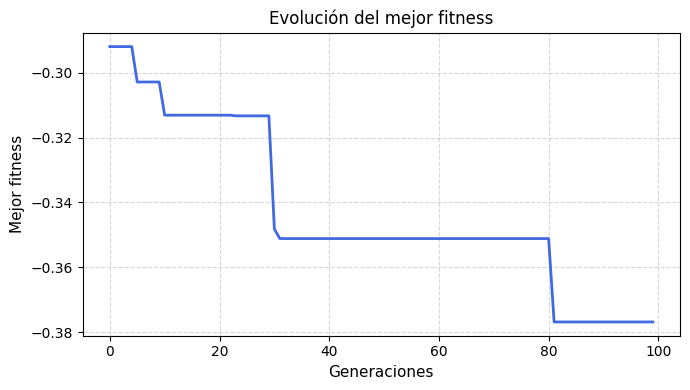

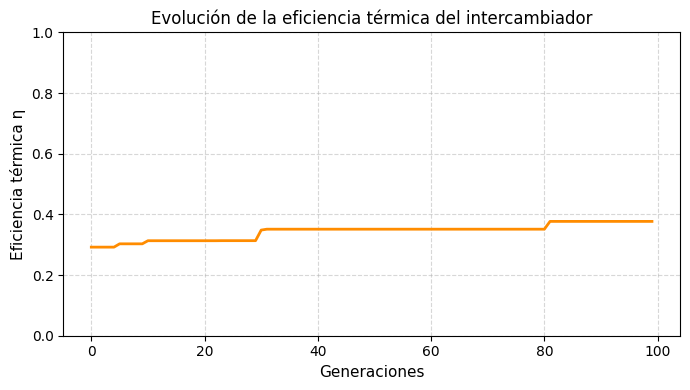

<Figure size 900x300 with 0 Axes>

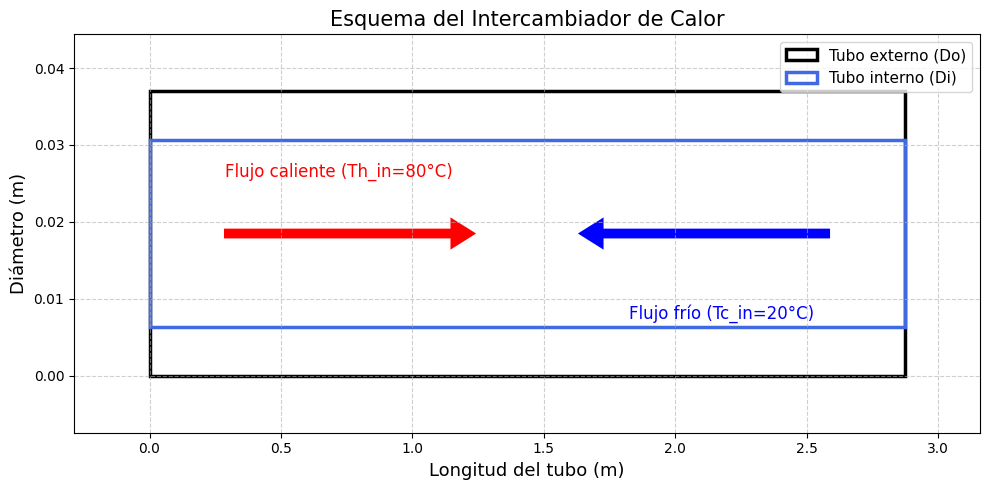

In [22]:
from matplotlib.patches import Rectangle, FancyArrow

plt.figure(figsize=(7,4))
plt.plot(hist_best, color='royalblue', linewidth=2)
plt.xlabel('Generaciones', fontsize=11)
plt.ylabel('Mejor fitness', fontsize=11)
plt.title('Evolución del mejor fitness', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(hist_eta, color='darkorange', linewidth=2)
plt.xlabel('Generaciones', fontsize=11)
plt.ylabel('Eficiencia térmica η', fontsize=11)
plt.title('Evolución de la eficiencia térmica del intercambiador', fontsize=12)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,3))

plt.figure(figsize=(10, 5))

# Tubo externo (Do)
outer = Rectangle((0, 0), L, Do, fill=False, edgecolor='black',
                    linewidth=2.5, label='Tubo externo (Do)')

# Tubo interno (Di)
inner = Rectangle((0, (Do - Di)/2), L, Di, fill=False, edgecolor='royalblue',
                    linewidth=2.5, label='Tubo interno (Di)')

plt.gca().add_patch(outer)
plt.gca().add_patch(inner)

y_hot_arrow = (Do - Di)/2 + Di * 0.5
y_cold_arrow = Do * 0.5

plt.arrow(0.1*L, y_hot_arrow, 0.3*L, 0,
          head_width=Do*0.1, head_length=L*0.03, fc='red', ec='red', linewidth=1.5)
plt.text(0.1*L, y_hot_arrow + Do*0.2, "Flujo caliente (Th_in=80°C)",
         color='red', fontsize=12)

plt.arrow(0.9*L, y_cold_arrow, -0.3*L, 0,
          head_width=Do*0.1, head_length=L*0.03, fc='blue', ec='blue', linewidth=1.5)
plt.text(0.88*L, y_cold_arrow - Do*0.3, "Flujo frío (Tc_in=20°C)",
         color='blue', fontsize=12, ha='right')

plt.xlim(-0.1*L, L + 0.1*L)
plt.ylim(-Do*0.2, Do + Do*0.2)

plt.xlabel("Longitud del tubo (m)", fontsize=13)
plt.ylabel("Diámetro (m)", fontsize=13)
plt.title("Esquema del Intercambiador de Calor", fontsize=15)
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()